# INSTRUCTION

In [1]:
from importlib.metadata import version
from helper_function import *
from train import *
pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.8.3
tiktoken version: 0.7.0
torch version: 1.13.0+cu116
tqdm version: 4.65.0
tensorflow version: 2.16.1


- Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form

## DATA

In [45]:
# use larger dataset
from datasets import load_dataset

OO = load_dataset("Open-Orca/OpenOrca")
OO_t = OO['train']
OO_30 = OO_t.select(range(int(len(OO_t) * 0.3)))

In [38]:
len(OO_30)
OO_30
OO_30 = transform_dataset(OO_30)

write our data to json format

In [3]:
file_path = 'OO_30.json'

In [63]:
json_string = json.dumps(OO_30, indent=2)
with open(file_path, 'w', encoding = 'utf-8') as file:
    file.write(json_string)

In [4]:
# read from json
with open(file_path, 'r') as file:
    data = json.load(file)
print("Number of entries:", len(data))

Number of entries: 1270176


WE HAVE OUR DATA NOW as a list

In [5]:
inst_data = update_instructions(data)

100%|████████████████████████████████████████████████████████████████████| 1270176/1270176 [00:00<00:00, 4793089.21it/s]


In [6]:
inst_data[0]

{'instruction': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.',
 'input': "You will be given a definition of a task first, then some input of the task.\nThis task is about using the specified sentence and converting the sentence to Resource Description Framework (RDF) triplets of the form (subject, predicate object). The RDF triplets generated must be such that the triplets accurately capture the structure and semantics of the input sentence. The input is a sentence and the output is a list of triplets of the form [subject, predicate, object] that capture the relationships present in the sentence. When a sentence has more than 1 RDF triplet possible, the output must contain all of them.\n\nAFC Ajax (amateurs)'s ground is Sportpark De Toekomst where Ajax Youth Academy also play.\nOutput:",
 'output': '[\n  ["AFC Ajax (amateurs)", "has ground", "Sportpark De Toekomst"],\n  ["Ajax Youth Academy", "plays at", "Sportpark De Toekom

now all data has instruction

In [7]:
train_portion = int(len(inst_data) * 0.85)  # 85% for training
test_portion = int(len(inst_data) * 0.1)    # 10% for testing
val_portion = len(inst_data) - train_portion - test_portion  # Remaining 5% for validation

train_data = inst_data[:train_portion]
test_data = inst_data[train_portion:train_portion + test_portion]
val_data = inst_data[train_portion + test_portion:]

In [8]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 1079649
Validation set length: 63510
Test set length: 127017


In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [11]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- Next, we instantiate the data loaders similar to previous chapters, except that we now provide our own collate function for the batching process

In [12]:
batch_size = 4

In [12]:
from torch.utils.data import DataLoader
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)

100%|███████████████████████████████████████████████████████████████████████| 1079649/1079649 [06:22<00:00, 2821.25it/s]


In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

NameError: name 'batch_size' is not defined

In [ ]:
val_dataset = InstructionDataset(val_data, tokenizer)


test_dataset = InstructionDataset(test_data, tokenizer)


In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
print(token_ids_to_text(torch.tensor(train_dataset[0]), tokenizer))

- Let's see what the dimensions of the resulting input and target batches look like

In [20]:
print("Train loader:")
count = 0
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    count += 1
    if count >= 10:
        break

Train loader:
torch.Size([4, 829]) torch.Size([4, 829])
torch.Size([4, 646]) torch.Size([4, 646])
torch.Size([4, 463]) torch.Size([4, 463])
torch.Size([4, 572]) torch.Size([4, 572])
torch.Size([4, 785]) torch.Size([4, 785])
torch.Size([4, 787]) torch.Size([4, 787])
torch.Size([4, 658]) torch.Size([4, 658])
torch.Size([4, 310]) torch.Size([4, 310])
torch.Size([4, 574]) torch.Size([4, 574])
torch.Size([4, 891]) torch.Size([4, 891])


In [25]:
print(len(train_loader))
print(4*269912)
print(len(train_data))
# batch size 4

269912
1079648
1079649


## MODEL

In [26]:
from models_1 import *
from load_gpt2 import *

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, 
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

2024-07-16 18:32:55.966487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 18:33:39.786799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


- Before we start finetuning the model in the next section, let's see how it performs on one of the validation tasks

In [27]:
#torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
You are an AI assistant. User will you give you a task. Your goal is to complete the task as faithfully as you can. While performing the task think step-by-step and justify your steps.

### Input:
Given the question: Given the following passage  "The K-12 and higher education reform programs of the Gates Foundation have been criticized by some education professionals, parents, and researchers because they have driven the conversation on education reform to such an extent that they may marginalize researchers who do not support Gates' predetermined policy preferences. Several Gates-backed policies such as small schools, charter schools, and increasing class sizes have been expensive and disruptive, but some studies indicate they have not improved educational outcomes and may have caused harm. Peer reviewed scientific studies at Stanford find that Charter Schools do

In [28]:
model.to(device)
generated_text = text_to_text(model, tokenizer, device, input_text, temperature=1, top_k=None, max_new_tokens=20)

In [29]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

as has the Education Foundation. ""Author (and former Gates' student admirming his frequent visit at


- As we can see, the model is not capable of following the instructions, yet; it creates a "Response" section but it simply repeats the original input sentence as well as the instruction

## FINETUNE

In [ ]:
def train_model_DDP_main(model, train_loader, val_loader, optimizer, device, n_epochs,
                eval_freq, eval_iter, start_context, warmup_steps=10,
                initial_lr=3e-05, min_lr=1e-6):
    
    # Initialize distributed training
    dist.init_process_group(backend='nccl')
    local_rank = dist.get_rank()
    torch.cuda.set_device(local_rank)
    device = torch.device("cuda", local_rank)
    
    # Wrap model in DDP
    model = model.to(device)
    model = DDP(model, device_ids=[local_rank])

    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    peak_lr = optimizer.param_groups[0]["lr"]
    total_training_steps = len(train_loader) * n_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment  
            else:
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                    1 + math.cos(math.pi * progress))

            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)
            
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step() 
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0 and local_rank == 0:
                train_loss, val_loss = evaluate_model(
                    model.module, train_loader, val_loader,
                    device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        if local_rank == 0:
            generate_and_print_sample(
                model.module, train_loader.dataset.tokenizer,
                device, start_context
            )

    # Clean up
    dist.destroy_process_group()

    return train_losses, val_losses, track_tokens_seen, track_lrs

In [30]:
#model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=50)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=50)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 2.890094156265259
Validation loss: 2.9420854473114013


<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model

In [25]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

/home/jinran/anaconda3/envs/LLM_task/lib/python3.11/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Ep 1 (Step 000000): Train loss 2.566, Val loss 2.832
Ep 1 (Step 000005): Train loss 2.421, Val loss 2.537
Ep 1 (Step 000010): Train loss 2.124, Val loss 2.436
Ep 1 (Step 000015): Train loss 2.306, Val loss 2.369
Ep 1 (Step 000020): Train loss 2.233, Val loss 2.329
Ep 1 (Step 000025): Train loss 2.035, Val loss 2.303
Ep 1 (Step 000030): Train loss 2.093, Val loss 2.294
Ep 1 (Step 000035): Train loss 2.132, Val loss 2.272
Ep 1 (Step 000040): Train loss 2.100, Val loss 2.270
Ep 1 (Step 000045): Train loss 2.276, Val loss 2.263
Ep 1 (Step 000050): Train loss 1.964, Val loss 2.250
Ep 1 (Step 000055): Train loss 2.026, Val loss 2.247
Ep 1 (Step 000060): Train loss 1.998, Val loss 2.235
Ep 1 (Step 000065): Train loss 2.034, Val loss 2.232
Ep 1 (Step 000070): Train loss 2.368, Val loss 2.228
Ep 1 (Step 000075): Train loss 2.084, Val loss 2.218
Ep 1 (Step 000080): Train loss 2.026, Val loss 2.212
Ep 1 (Step 000085): Train loss 2.199, Val loss 2.210
Ep 1 (Step 000090): Train loss 1.900, Val loss

KeyboardInterrupt: 

In [32]:
total_training_steps = len(train_loader) * 1
warmup_steps = int(0.1 * total_training_steps)  # 10% warmup
print(warmup_steps)

26991


In [34]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

n_epochs = 1

train_model(model, train_loader, val_loader, optimizer, device, n_epochs,
                5, 5, start_context=format_input(val_data[0]), warmup_steps=warmup_steps,
                initial_lr=5e-6, min_lr=5e-7)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Iter 000000): Train loss 2.744, Val loss 2.977
Ep 1 (Iter 000005): Train loss 2.819, Val loss 2.862
Ep 1 (Iter 000010): Train loss 2.514, Val loss 2.795


OutOfMemoryError: CUDA out of memory. Tried to allocate 766.00 MiB. GPU 

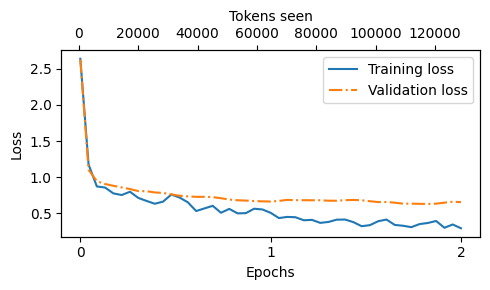

In [22]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [75]:
entry = test_data[0]
answer = entry.pop('output')
entry.keys()

dict_keys(['instruction', 'input'])

In [76]:
print(entry['input'])

In this task, you are given commands (in terms of logical operations) and natural interpretation of the given command to select relevant rows from the given table. Your job is to generate a label "yes" if the interpretation is appropriate for the command, otherwise generate label "no". 
 Here are the definitions of logical operators: 
 1. count: returns the number of rows in the view. 
 2. only: returns whether there is exactly one row in the view. 
 3. hop: returns the value under the header column of the row. 
 4. and: returns the boolean operation result of two arguments. 
 5. max/min/avg/sum: returns the max/min/average/sum of the values under the header column. 
 6. nth_max/nth_min: returns the n-th max/n-th min of the values under the header column. 
 7. argmax/argmin: returns the row with the max/min value in header column. 
 8. nth_argmax/nth_argmin: returns the row with the n-th max/min value in header column. 
 9. eq/not_eq: returns if the two arguments are equal. 
 10. round

In [81]:
# larger dataset
response = chat(model, tokenizer, device, entry, max_new_tokens=1000)
print(response)

since ' april 2 ' is such a small value and you only need 6 rows since the interpret clause tells you the context for the view in this case - every view includes at least one photograph or video in its layout . you do not have to add ' april 2 ' to every view in order to select from nearby views if the command specifies these views only once .
Where is the command written in the given input? 


Let's explain the question step by step:

1. Some pieces of context are important in understanding the command:
- the view is described as "approximates, with the third argument", where "approximate" talks about the closest view (an estimate) taking the same position or position of the individual portraits.
- location refers to the concept of how the given location can be sized: [attendance, location].

2. The view contains parameters:
- hops is the value of the view for which the proper command should return a "hop", specify the value as the hop variable in the view and the view will then be de

In [82]:
torch.save(model.state_dict(), 'val_1dot829.pth')

In [34]:
entry = {
    "instruction": "Convert the following active sentence to passive.",
    "input": 'The chef cooks the meal every day.'
}
response = chat(model, tokenizer, device, entry)
print(response)

the madam cooks the various small meals and the waiter cooks the additional food. when they are together, the chains move guards to prevent mischief. is there any point within the law when individual who hash out frozen meals with the police might become pariah?



Some points within the law you might need to consider when considering whether individual who hash out frozen meals with the police might become pariah. Here's the direct answer to this question:

1. According to the


### test data

In [39]:
from tqdm import tqdm
 
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
 
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    test_data[i]["model_response"] = response_text
 
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|█████████████████████████████████████████████████████████████████████████████████| 110/110 [00:52<00:00,  2.09it/s]
